# Tarea 3: Análisis Espectral (FFT) y Espectrogramas

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

ruta_csv = "data/ener_clean.csv"   
col = "Ener_4"
fs = 2000                    
snr_db = 8            

# Cargar CSV y extraer serie clean

df = pd.read_csv(ruta_csv)

if col not in df.columns:
    raise ValueError(f"No encontré la columna '{col}'. Columnas disponibles: {list(df.columns)}")

x_clean = pd.to_numeric(df[col], errors="coerce").dropna().to_numpy(dtype=float)

if len(x_clean) < 32:
    raise ValueError("La señal es muy corta después de eliminar NaN. Revisa el CSV/columna.")

print("Muestras (clean):", len(x_clean))
print("fs:", fs, "Hz")


# Funciones: ruido por SNR, PSD por FFT, banda de ruido

def add_noise_snr(x, snr_db, seed=123):
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=float)
    p_signal = np.mean(x**2)
    snr_lin = 10**(snr_db / 10.0)
    p_noise = p_signal / snr_lin
    noise = rng.normal(0, np.sqrt(p_noise), size=x.shape)
    return x + noise

def psd_fft(x, fs, window="hann"):
    x = np.asarray(x, dtype=float)
    n = len(x)

    if window == "hann":
        w = np.hanning(n)
    elif window is None:
        w = np.ones(n)
    else:
        raise ValueError("window soportadas: 'hann' o None")

    xw = x * w
    X = np.fft.rfft(xw)
    f = np.fft.rfftfreq(n, d=1/fs)

    # PSD aproximada: |X|^2 / (fs * sum(w^2))
    Pxx = (np.abs(X)**2) / (fs * np.sum(w**2))
    return f, Pxx

def noise_band_from_psd(f, P_clean, P_noisy, top_frac=0.10):
    diff = np.maximum(P_noisy - P_clean, 0)
    if np.all(diff == 0):
        return None
    thr = np.quantile(diff, 1 - top_frac)
    idx = np.where(diff >= thr)[0]
    return float(f[idx].min()), float(f[idx].max()), diff


# Crear señal con ruido (noise)

x_noisy = add_noise_snr(x_clean, snr_db=snr_db)



Muestras (clean): 2000
fs: 2000 Hz


#### PSD (FFT) y comparación

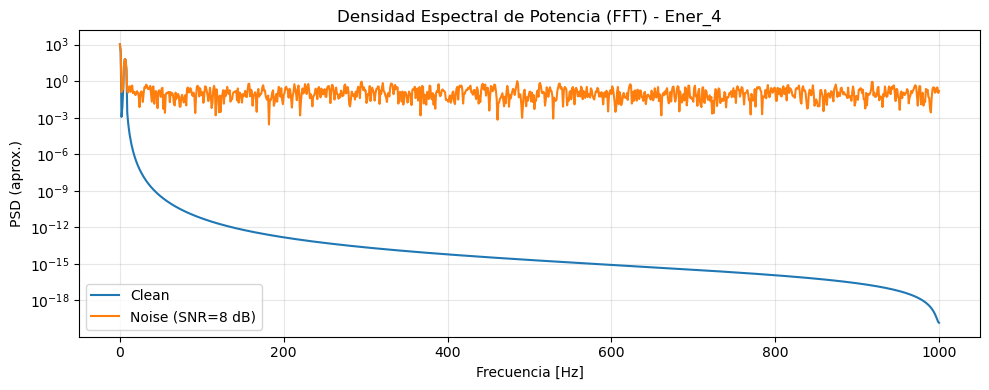

[PSD] Ruido concentrado (top 10% del exceso): 0.00 Hz – 977.00 Hz


In [12]:
f, P_clean = psd_fft(x_clean, fs, window="hann")
_, P_noisy = psd_fft(x_noisy, fs, window="hann")

plt.figure(figsize=(10,4))
plt.semilogy(f, P_clean + 1e-20, label="Clean")
plt.semilogy(f, P_noisy + 1e-20, label=f"Noise (SNR={snr_db} dB)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD (aprox.)")
plt.title("Densidad Espectral de Potencia (FFT) - Ener_4")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Rango donde se concentra el ruido (según PSD)
res = noise_band_from_psd(f, P_clean, P_noisy, top_frac=0.10)
if res is None:
    print("No se detectó exceso espectral (P_noisy <= P_clean).")
else:
    fmin, fmax, diff_psd = res
    print(f"[PSD] Ruido concentrado (top 10% del exceso): {fmin:.2f} Hz – {fmax:.2f} Hz")


#### Espectrogramas (clean vs noise)

Parámetros típicos: ajústalos si tu señal es muy corta/larga


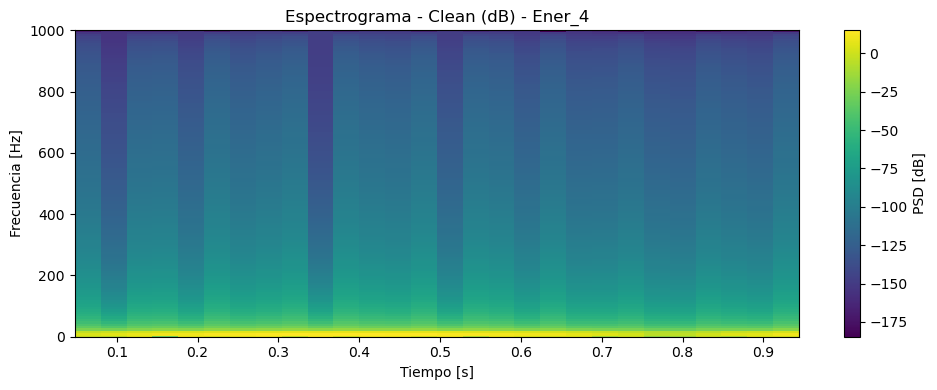

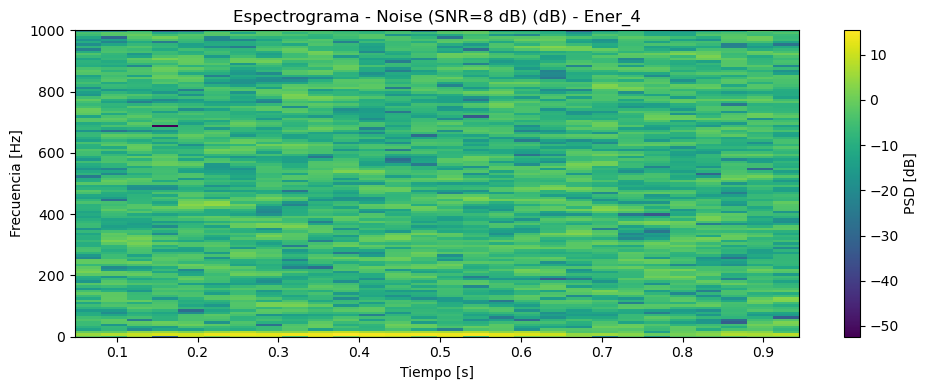

In [13]:
nperseg = 256
noverlap = 192
if len(x_clean) < nperseg:
    nperseg = max(32, 2**int(np.floor(np.log2(len(x_clean)))))
    noverlap = int(0.75 * nperseg)

f1, t1, S1 = signal.spectrogram(
    x_clean, fs=fs, window="hann",
    nperseg=nperseg, noverlap=noverlap,
    scaling="density", mode="psd"
)

f2, t2, S2 = signal.spectrogram(
    x_noisy, fs=fs, window="hann",
    nperseg=nperseg, noverlap=noverlap,
    scaling="density", mode="psd"
)

plt.figure(figsize=(10,4))
plt.pcolormesh(t1, f1, 10*np.log10(S1 + 1e-20), shading="auto")
plt.ylabel("Frecuencia [Hz]")
plt.xlabel("Tiempo [s]")
plt.title("Espectrograma - Clean (dB) - Ener_4")
plt.colorbar(label="PSD [dB]")
plt.ylim(0, fs/2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.pcolormesh(t2, f2, 10*np.log10(S2 + 1e-20), shading="auto")
plt.ylabel("Frecuencia [Hz]")
plt.xlabel("Tiempo [s]")
plt.title(f"Espectrograma - Noise (SNR={snr_db} dB) (dB) - Ener_4")
plt.colorbar(label="PSD [dB]")
plt.ylim(0, fs/2)
plt.tight_layout()
plt.show()


#### Comparación directa: exceso espectral en espectrograma

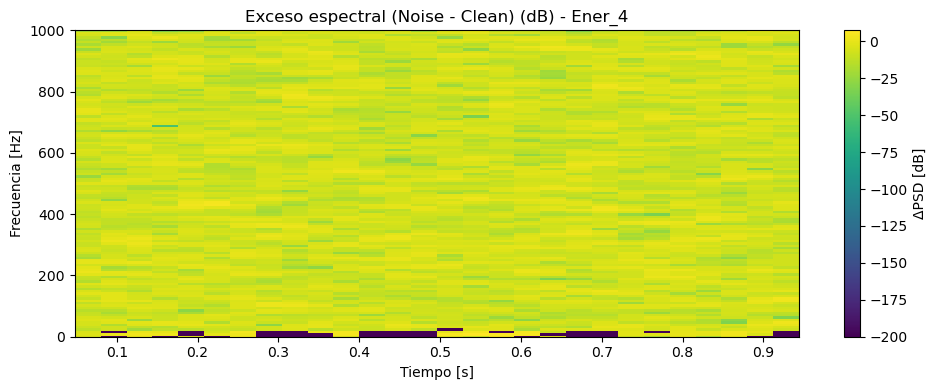

[Espectrograma] Ruido concentrado (top 10%): 7.81 Hz – 921.88 Hz


In [14]:
Sdiff = np.maximum(S2 - S1, 0)

plt.figure(figsize=(10,4))
plt.pcolormesh(t2, f2, 10*np.log10(Sdiff + 1e-20), shading="auto")
plt.ylabel("Frecuencia [Hz]")
plt.xlabel("Tiempo [s]")
plt.title("Exceso espectral (Noise - Clean) (dB) - Ener_4")
plt.colorbar(label="ΔPSD [dB]")
plt.ylim(0, fs/2)
plt.tight_layout()
plt.show()

# Rango donde se concentra el ruido (según espectrograma, promedio en el tiempo)
mean_diff_f = Sdiff.mean(axis=1)
thr = np.quantile(mean_diff_f, 0.90)  # top 10%
idx = np.where(mean_diff_f >= thr)[0]
if len(idx) > 0:
    print(f"[Espectrograma] Ruido concentrado (top 10%): {f2[idx].min():.2f} Hz – {f2[idx].max():.2f} Hz")
else:
    print("[Espectrograma] No se detectó banda dominante de exceso.")


# Tarea 4: Filtrado y Reconstrucción

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

path_noise = "data/agro_noise.csv"
col = "Agro_3"

fs = 2000       
cutoff_hz = 5   
order = 4  

df = pd.read_csv(path_noise)

if col not in df.columns:
    raise ValueError(f"No encontré '{col}'. Columnas disponibles: {list(df.columns)}")

x_original = pd.to_numeric(df[col], errors="coerce").dropna().to_numpy(dtype=float)

if len(x_original) < 32:
    raise ValueError("Muy pocas muestras para aplicar el filtro.")

t = np.arange(len(x_original)) / fs

print("Muestras:", len(x_original))

Muestras: 2000


#### FILTRO BUTTERWORTH PASO BAJO

In [16]:

nyq = fs / 2
Wn = cutoff_hz / nyq

if not (0 < Wn < 1):
    raise ValueError(f"cutoff_hz debe estar entre 0 y {nyq} Hz")

b, a = signal.butter(order, Wn, btype='low')
x_filtered = signal.filtfilt(b, a, x_original)


####  RMSE (antes vs después)

RMSE (original vs filtrada): 5.391936


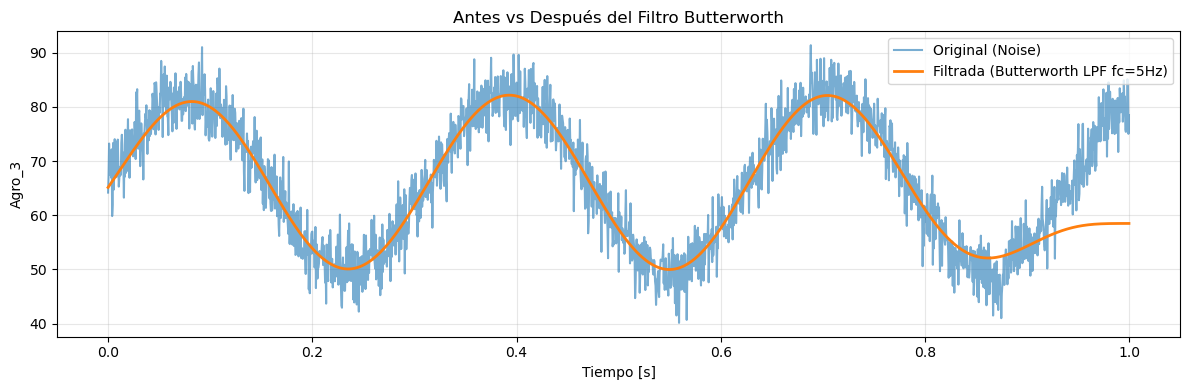

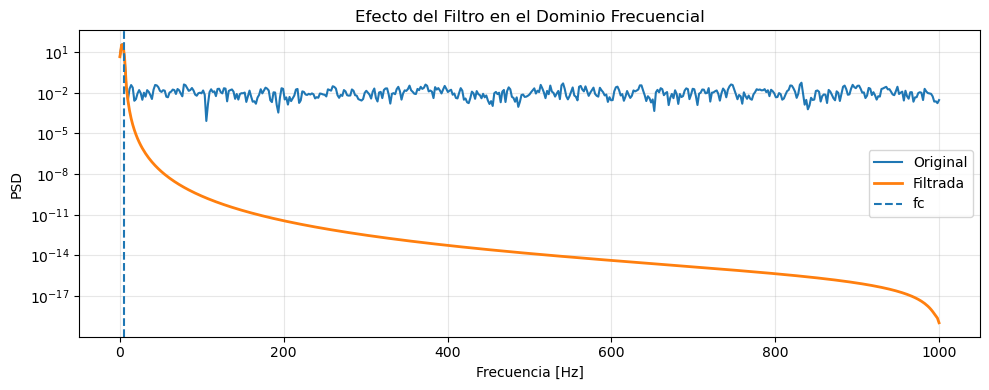

In [17]:
def rmse(x1, x2):
    return np.sqrt(np.mean((x1 - x2)**2))

rmse_value = rmse(x_original, x_filtered)

print(f"RMSE (original vs filtrada): {rmse_value:.6f}")


#  GRÁFICA EN TIEMPO

plt.figure(figsize=(12,4))
plt.plot(t, x_original, label="Original (Noise)", alpha=0.6)
plt.plot(t, x_filtered, label=f"Filtrada (Butterworth LPF fc={cutoff_hz}Hz)", linewidth=2)
plt.xlabel("Tiempo [s]")
plt.ylabel("Agro_3")
plt.title("Antes vs Después del Filtro Butterworth")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# 6COMPARACIÓN ESPECTRAL (opcional pero recomendado)

f, P_original = signal.welch(x_original, fs=fs, nperseg=min(1024, len(x_original)))
_, P_filtered = signal.welch(x_filtered, fs=fs, nperseg=min(1024, len(x_filtered)))

plt.figure(figsize=(10,4))
plt.semilogy(f, P_original + 1e-20, label="Original")
plt.semilogy(f, P_filtered + 1e-20, label="Filtrada", linewidth=2)
plt.axvline(cutoff_hz, linestyle="--", label="fc")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD")
plt.title("Efecto del Filtro en el Dominio Frecuencial")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Pregunta: El filtrado mejora la capacidad predictiva del modelo?

Respuesta: